# Supraconvergence

## A simple dG derivative

We start by studying the first derivative in 1d
\begin{align}
g(x) = \frac{\partial f}{\partial x}
\end{align}

In [68]:
import numpy as np
import pyfeltor.dg as dg
import matplotlib.pyplot as plt

In [69]:
g = dg.Grid( x0 = 0, x1 = np.pi, n = 3, N = 5)
equi = dg.Grid( g.x0, g.x1, 1, 300)
xc = dg.evaluate( lambda x : x, g)
xs = dg.evaluate( lambda x : x, equi)
interp = dg.create.interpolation( [dg.evaluate( lambda x : x, equi)], g, bcs = [dg.bc.PER])

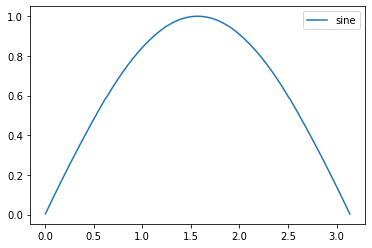

In [70]:
sine = dg.evaluate( np.sin, g)
plt.plot( xs, interp.dot(sine), label = 'sine')
plt.legend()
plt.show()

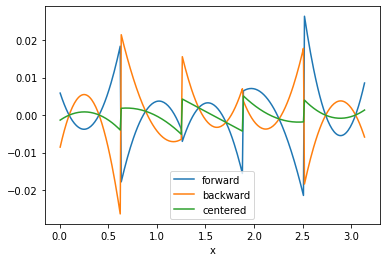

In [71]:
# 1st derivative
xs = dg.evaluate( lambda x : x, equi)
ana = dg.evaluate( np.cos, g)
for direct in [dg.direction.forward, dg.direction.backward, dg.direction.centered]:
    dx = dg.create.dx( 0, g, dg.bc.DIR, direct)
    derivative = dx.dot( sine)

    plt.plot( xs, interp.dot(ana  - derivative), label = direct.name)
plt.xlabel("x")
plt.legend()
plt.show()

The centered derivative is the average between foward and backward derivative

Let us try a spline and finite differences for comparison

In [72]:
# https://github.com/maroba/findiff
from findiff import FinDiff

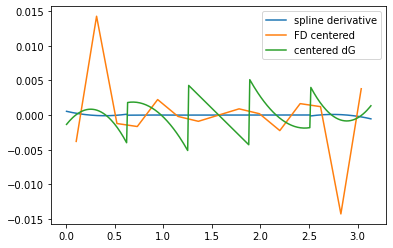

In [74]:
import scipy.interpolate

spl = scipy.interpolate.UnivariateSpline(xc, sine, k=4, s=0)

spline = dg.evaluate( spl.derivative(1), g)
# for finite difference formula let us interpolate on equidistant grid and derive
equi_g = dg.Grid( g.x0, g.x1, 1, g.n*g.N)
xg = dg.evaluate( lambda x: x, equi_g)
ana_g = dg.evaluate( np.cos, equi_g)
inter_equ = dg.create.interpolation ( [dg.evaluate( lambda x: x, equi_g) ], g, [dg.bc.DIR])
equidist_sine = inter_equ.dot( dg.evaluate( np.sin, g))
d_dx = FinDiff( 0, equi_g.h()[0], acc = 4)

plt.plot( xs, interp.dot(ana - spline), label = 'spline derivative')
plt.plot( xg, ana_g - d_dx(equidist_sine), label = 'FD centered')
plt.plot( xs, interp.dot(ana - derivative), label = 'centered dG')
plt.legend()
plt.show()


Clearly a spline derivative is much better than a dG derivative or a finite difference for that matter

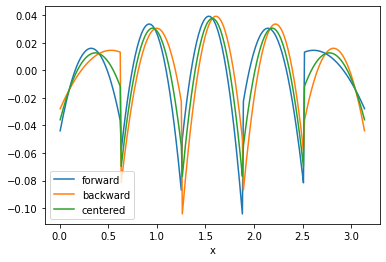

In [64]:
ana = dg.evaluate( np.sin, g)
for direct in [dg.direction.forward, dg.direction.backward, dg.direction.centered]:
    dx = dg.create.dx( 0, g, dg.bc.DIR, dg.direction.centered)
    dxx = dg.create.dx( 0, g, dg.bc.NEU, direct) @ dx
    derivative = -dxx.dot( sine) 

    plt.plot( xs, interp.dot( ana  - derivative), label = direct.name)
plt.xlabel("x")
plt.legend()
plt.show()

## A Laplace solve

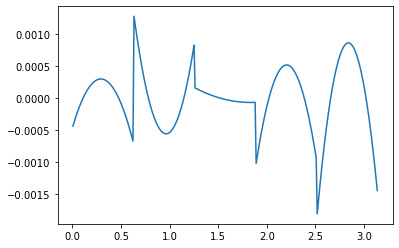

In [77]:
import scipy
pol_forward = dg.create.elliptic(
    g,
    [dg.bc.DIR],
    [dg.direction.forward],
    sigma=np.ones( g.size()),
    jumpfactor=1,
)
b = dg.evaluate( np.sin, g)
ana = dg.evaluate( np.sin, g)
# use a direct solver to solve linear equation
x = scipy.sparse.linalg.spsolve(pol_forward, b)
plt.plot( xs, interp.dot(x-ana))
plt.show()

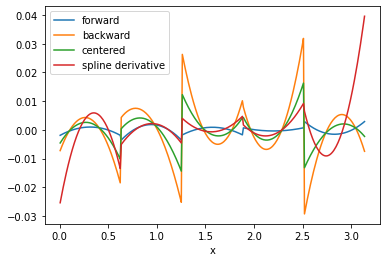

In [84]:

xs = dg.evaluate( lambda x : x, equi)
ana = dg.evaluate( np.cos, g)
for direct in [dg.direction.forward, dg.direction.backward, dg.direction.centered]:
    dx = dg.create.dx( 0, g, dg.bc.DIR, direct)
    derivative = dx.dot( x)

    plt.plot( xs, interp.dot( ana - derivative), label = direct.name)
spl = scipy.interpolate.UnivariateSpline(xc, x, k=3, s=0)
spline = dg.evaluate( spl.derivative(1), g)
plt.plot( xs, interp.dot( ana - spline), label = 'spline derivative')
plt.xlabel("x")
plt.legend()
plt.show()

- The forward derivative has the smallest oscillations
- The spline now also has oscillations


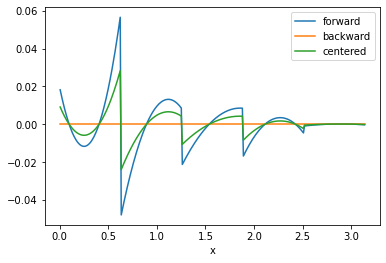

In [88]:
ana = dg.evaluate( np.sin, g)
for direct in [dg.direction.forward, dg.direction.backward, dg.direction.centered]:
    dx = dg.create.dx( 0, g, dg.bc.DIR, dg.direction.forward)
    dxx = dg.create.dx( 0, g, dg.bc.NEU, direct) @ dx
    derivative = -dxx.dot( x) + jump.dot(x)

    plt.plot( xs, interp.dot( ana - derivative), label = direct.name)
# Spline is very bad
# spl = scipy.interpolate.UnivariateSpline(xc, x, k=4, s=0)

# spline = -dg.evaluate( spl.derivative(2), g)
# plt.plot( xs, interp.dot( ana - spline), label = 'spline derivative')
plt.xlabel("x")
plt.legend()
plt.show()

The backward 2nd derivative is correct only together with the jump term

## Polarization solve with chi

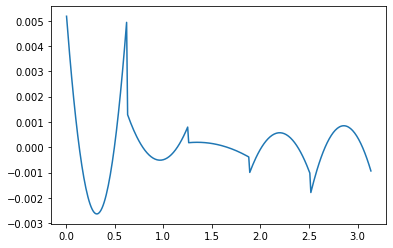

In [91]:
amp = 0.9
pol = lambda x: 1 + amp * np.sin(x)
rhs = lambda x: np.sin(x) * (amp * np.sin(x) + 1) - amp * np.cos(x) * np.cos(x)
sol = lambda x: np.sin(x)

pol_forward = dg.create.elliptic(
    g,
    [dg.bc.DIR],
    [dg.direction.forward],
    sigma=dg.evaluate(pol,g),
    jumpfactor=1,
)
b = dg.evaluate( rhs, g)
ana = dg.evaluate( sol, g)
# use a direct solver to solve linear equation
x = scipy.sparse.linalg.spsolve(pol_forward, b)
plt.plot( xs, interp.dot(x-ana))
plt.show()

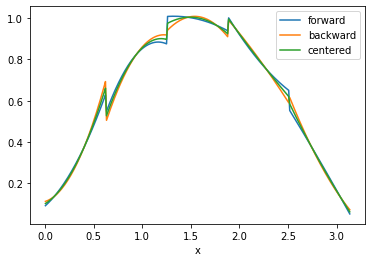

In [92]:
ana = dg.evaluate( np.sin, g)
for direct in [dg.direction.forward, dg.direction.backward, dg.direction.centered]:
    dx = dg.create.dx( 0, g, dg.bc.DIR, dg.direction.forward)
    dxx = dg.create.dx( 0, g, dg.bc.NEU, direct) @ dx
    derivative = -dxx.dot( x) + jump.dot(x)

    plt.plot( xs, interp.dot(derivative), label = direct.name)
plt.xlabel("x")
plt.legend()
plt.show()

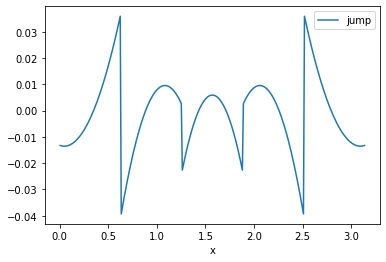

In [90]:
jump = dg.create.jump( 0, g, dg.bc.DIR)
jumpy = jump.dot( sine)
plt.plot( xs, interp.dot(jumpy), label = 'jump')
plt.xlabel("x")
plt.legend()
plt.show()